In [1]:


import pickle
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from team_mappings import *
from utility_functions import *

%matplotlib inline

In [2]:

def remove_dups(l: list):
    unique_list = []
    for item in l:
        # If the item is not already in the unique list, add it
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

In [3]:


current_season_start_year = get_nba_season_year() - 1
print(f'Training with data up to {current_season_start_year}')

mvp_data_dir = '../Basketball Reference Stat Scraper/Awards/MVP'
player_data_dir = '../Basketball Reference Stat Scraper/player_stats/'
team_data_dir = '../Basketball Reference Stat Scraper/team_stats/'

full_data = []
for year in range(1980, current_season_start_year + 1):
    player_data = pd.read_csv(os.path.join(player_data_dir, f'{year}_player_stats.csv'), index_col=0)
    mvp_data = pd.read_csv(os.path.join(mvp_data_dir, f'{year}_MVP.csv'), index_col=0)
    team_data = pd.read_csv(os.path.join(team_data_dir, f'{year}_tm_stats.csv'), index_col=0)

    # Convert 'Tm' to full team names in player and mvp data
    # Note: 'team_mapping_inverted' needs to be defined earlier in your code
    player_data['Tm'] = player_data['Tm'].map(team_mapping_inverted).fillna(player_data['Tm'])
    mvp_data['Tm'] = mvp_data['Tm'].map(team_mapping_inverted).fillna(mvp_data['Tm'])

    # Process MVP data
    mvp_data = mvp_data[mvp_data['Share'] > 0]
    mvp_data['MVP_Rank'] = mvp_data['Share'].rank(ascending=False)

    # Process team data
    team_data['Team'] = team_data['Team'].map(team_mapping_inverted).fillna(team_data['Team'])
    team_data['Team'] = team_data['Team'].str.strip('*')
    team_data = team_data[~team_data['Team'].str.contains('League')]
    team_data['Win%'] = team_data.W / team_data.G
    team_data['League_Rank'] = team_data['Win%'].rank(ascending=False)
    team_data['Conference'] = team_data['Team'].map(
        team_conference_mapping)  # 'team_conference_mapping' needs definition
    team_data['Conference_Rank'] = team_data.groupby('Conference')['Win%'].rank(ascending=False)
    team_data['playoff_status'] = team_data['Conference_Rank'].apply(lambda x: 1 if x <= 8 else 0)

    team_data['DRtg_Rank'] = team_data.DRtg.rank(method='min')
    team_data['ORtg_Rank'] = team_data.ORtg.rank(ascending=False, method='min')

    # Rename team data columns correctly
    team_data = team_data.rename(
        columns={col: f'Team_{col}' for col in team_data.columns if col not in ['Team', 'Year']})

    # Merge player data with MVP data
    merged_data = pd.merge(
        player_data.assign(Player=lambda df: df.Player.str.strip('*')),
        mvp_data,
        how='left'
    ).fillna(0)

    # Merge with team data using full team names
    merged_data = pd.merge(
        merged_data,
        team_data,
        left_on=['Tm', 'Year'],
        right_on=['Team', 'Year'],
        how='left'
    ).fillna(0)

    # Select columns to calculate the stats
    columns_to_calculate = ['Team_FG', 'Team_FGA', 'Team_FG%', 'Team_3P', 'Team_3PA', 'Team_3P%',
                            'Team_2P', 'Team_2PA', 'Team_2P%', 'Team_FT', 'Team_FTA', 'Team_FT%',
                            'Team_ORB', 'Team_DRB', 'Team_TRB', 'Team_AST', 'Team_STL', 'Team_BLK',
                            'Team_TOV', 'Team_PF', 'Team_PTS', 'Team_MOV', 'Team_SOS', 'Team_SRS',
                            'Team_ORtg', 'Team_DRtg', 'Team_NRtg', 'Team_Pace', 'Team_FTr',
                            'Team_3PAr', 'Team_TS%', 'Team_Win%', 'Team_Age']

    # Calculate mean and standard deviation for the current year's team data
    mean_stats = team_data[columns_to_calculate].mean()
    std_stats = team_data[columns_to_calculate].std()

    # Compute raw differences and Z-scores for the selected team's statistics
    for col in columns_to_calculate:
        stat = col.replace('Team_', '')  # Extract the original stat name
        merged_data[f'{stat}_off_avg'] = merged_data[col] - mean_stats[col]
        merged_data[f'{stat}_Z'] = (merged_data[col] - mean_stats[col]) / std_stats[col]

    full_data.append(merged_data)

# Combine all data into a single DataFrame
df = pd.concat(full_data)
# for i in df.columns:
#     print(i)


Training with data up to 2023


In [4]:
year = 2004

In [5]:
# removed Win Shares in favor of WS/48
# Removed VORP Because it was like 90% of the feature importance graph

player_stats = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
               'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr',
               'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
                'WS/48', 'OBPM', 'DBPM', 'BPM', 'Team_Win%', 'Team_League_Rank',
               'Team_Conference_Rank', 'Team_playoff_status', 'Team_DRtg_Rank',
               'Team_ORtg_Rank', ]

model_result_viewing = [
    'Player', 'Pos', 'Age', 'Tm', 'Share', 'Year',
    'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
    'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
    'PER', 'VORP',
    'Team_League_Rank', 'Team_Conference_Rank', 'Team_DRtg_Rank', 'Team_ORtg_Rank',
]

basic_plus_normal_stats = player_stats + [

    'Team_FG', 'Team_FGA', 'Team_FG%', 'Team_3P', 'Team_3PA', 'Team_3P%', 'Team_2P',
    'Team_2PA', 'Team_2P%', 'Team_FT', 'Team_FTA', 'Team_FT%', 'Team_ORB', 'Team_DRB',
    'Team_TRB', 'Team_AST', 'Team_STL', 'Team_BLK', 'Team_TOV', 'Team_PF', 'Team_PTS',
    'Team_Age', 'Team_MOV', 'Team_SOS', 'Team_SRS', 'Team_ORtg',
    'Team_DRtg', 'Team_NRtg', 'Team_Pace', 'Team_FTr', 'Team_3PAr', 'Team_TS%',
]

basic_plus_z_score_stats = player_stats + [i for i in df.columns if '_Z' in i ]

basic_plus_off_avg_stats = player_stats + [i for i in df.columns if '_off_avg' in i ]





In [6]:
with pd.option_context('display.max_seq_items', None):
    print(df.columns)

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Year', 'First', 'Pts Won', 'Pts Max', 'Share', 'MVP_Rank', 'Team',
       'Team_G', 'Team_MP', 'Team_FG', 'Team_FGA', 'Team_FG%', 'Team_3P',
       'Team_3PA', 'Team_3P%', 'Team_2P', 'Team_2PA', 'Team_2P%', 'Team_FT',
       'Team_FTA', 'Team_FT%', 'Team_ORB', 'Team_DRB', 'Team_TRB', 'Team_AST',
       'Team_STL', 'Team_BLK', 'Team_TOV', 'Team_PF', 'Team_PTS', 'Team_Age',
       'Team_W', 'Team_L', 'Team_MOV', 'Team_SOS', 'Team_SRS', 'Team_ORtg',
       'Team_DRtg', 'Team_NRtg', 'Team_Pace', 'Team_FTr', 'Team_3PAr',
       'Team_TS%', 'Team_Win%', 'Team_League_Rank', 'Team_Conference',
       'Team_C

# Here's where you change the type of model you're running

In [94]:
feat_list = basic_plus_z_score_stats.copy()

X_test = df[df['Year'] == year][feat_list]
y_test = df[df['Year'] == year]['Share']

X_train = df[df['Year'] != year][feat_list]
y_train = df[df['Year'] != year]['Share']

print(X_test.columns)



Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'Team_Win%', 'Team_League_Rank',
       'Team_Conference_Rank', 'Team_playoff_status', 'Team_DRtg_Rank',
       'Team_ORtg_Rank', 'FG_Z', 'FGA_Z', 'FG%_Z', '3P_Z', '3PA_Z', '3P%_Z',
       '2P_Z', '2PA_Z', '2P%_Z', 'FT_Z', 'FTA_Z', 'FT%_Z', 'ORB_Z', 'DRB_Z',
       'TRB_Z', 'AST_Z', 'STL_Z', 'BLK_Z', 'TOV_Z', 'PF_Z', 'PTS_Z', 'MOV_Z',
       'SOS_Z', 'SRS_Z', 'ORtg_Z', 'DRtg_Z', 'NRtg_Z', 'Pace_Z', 'FTr_Z',
       '3PAr_Z', 'TS%_Z', 'Win%_Z', 'Age_Z'],
      dtype='object')


In [114]:
# Define the pipeline
pipe = Pipeline([
    ('feat_selection', 'passthrough'),
    ('scaler', 'passthrough'),
    ('reg', RandomForestRegressor())
])

# Define separate parameter grids
param_grid_percentile = {
    'feat_selection': [SelectPercentile()],  # Wrapped in a list
    'feat_selection__percentile': [j for j in range(50,101,10)],  # For SelectPercentile
    'feat_selection__score_func': [f_regression]
}

param_grid_kbest = {
    'feat_selection': [SelectKBest()],  # Wrapped in a list
    'feat_selection__k': [i for i in range(5,26,5)] + ['all'],  # For SelectKBest
    'feat_selection__score_func': [f_regression]
}

# Combine the parameter grids
combined_param_grid = [
    {**{'feat_selection': [SelectPercentile()]}, **param_grid_percentile},
    {**{'feat_selection': [SelectKBest()]}, **param_grid_kbest}
]

# Add common parameters to the combined grid
for grid in combined_param_grid:
    grid.update({
        'scaler': [MinMaxScaler(), StandardScaler()],
        'reg__n_estimators': [100],
        'reg__max_depth': [None, 10, 20]
    })

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=combined_param_grid, cv=4, n_jobs=-1, verbose=10,
                           scoring='neg_mean_squared_error')




model_results = []

for i in ['normal_stats','off_avg','z_score']:
    print(f'Running: {i}')

    if i == 'normal_stats':
        feat_list = basic_plus_normal_stats.copy()
    if i == 'off_avg':
        feat_list = basic_plus_off_avg_stats.copy()
    if i == 'z_score':
        feat_list = basic_plus_z_score_stats

    X_test = df[df['Year'] == year][feat_list]
    y_test = df[df['Year'] == year]['Share']

    X_train = df[df['Year'] != year][feat_list]
    y_train = df[df['Year'] != year]['Share']



    # Run the grid search
    grid_search.fit(X_train, y_train)

    # Output the results
    print("Best parameters found:", grid_search.best_params_)
    best_model = grid_search.best_estimator_



    # Making predictions on the test set
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    # Store the model's parameters and scores in a dictionary
    model_result = {
        'name': i,
        'params': grid_search.best_params_,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    }

    # Append the result to the list
    model_results.append(model_result)

    # Save the model results to a file (append mode to keep previous results)
    with open('model_results.pkl', 'ab') as file:
        pickle.dump(model_results, file)

    print(model_results)


Running: normal_stats
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best parameters found: {'feat_selection': SelectPercentile(), 'feat_selection__percentile': 50, 'feat_selection__score_func': <function f_regression at 0x7fbb1005f1f0>, 'reg__max_depth': None, 'reg__n_estimators': 100, 'scaler': StandardScaler()}
Fitting 4 folds for each of 72 candidates, totalling 288 fits
[{'name': 'normal_stats', 'params': {'feat_selection': SelectPercentile(), 'feat_selection__percentile': 50, 'feat_selection__score_func': <function f_regression at 0x7fbb1005f1f0>, 'reg__max_depth': 10, 'reg__n_estimators': 100, 'scaler': MinMaxScaler()}, 'mse': 0.0008187252860853431, 'rmse': 0.028613375999440246, 'r2': 0.7446931038635936}]
Running: off_avg
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best parameters found: {'feat_selection': SelectPercentile(), 'feat_selection__percentile': 50, 'feat_selection__score_func': <function f_regression at 0x7fbb1005f1f0>, 'reg__max_depth

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[{'name': 'off_avg', 'params': {'feat_selection': SelectPercentile(), 'feat_selection__percentile': 50, 'feat_selection__score_func': <function f_regression at 0x7fbb1005f1f0>, 'reg__max_depth': 20, 'reg__n_estimators': 100, 'scaler': StandardScaler()}, 'mse': 0.0007269530611897442, 'rmse': 0.026962067079319866, 'r2': 0.7733108615997156}]
Running: z_score
Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV 1/4; 4/72] START feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7fafd032adc0>, reg__max_depth=10, reg__n_estimators=100, scaler=StandardScaler()
[CV 1/4; 4/72] END feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7fafd032adc0>, reg__max_depth=10, reg__n_estimators=100, scaler=StandardScaler();, score=-0.001 total time=  24.1s
[CV 4/4; 5/72] START feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/4; 3/72] START feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7f95f84b3dc0>, reg__max_depth=10, reg__n_estimators=100, scaler=MinMaxScaler()
[CV 2/4; 3/72] END feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7f95f84b3dc0>, reg__max_depth=10, reg__n_estimators=100, scaler=MinMaxScaler();, score=-0.001 total time=  24.2s
[CV 2/4; 5/72] START feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7f95f84b3dc0>, reg__max_depth=20, reg__n_estimators=100, scaler=MinMaxScaler()
[CV 2/4; 5/72] END feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7f95f84b3dc0>, reg__max_depth=20, reg__n_estimators=100, scaler=MinMaxScaler();, score=-0.001 total time=  43.4s
[CV 2/4; 9/72] START feat_selection=SelectPercentile

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/4; 1/72] START feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7fa1684cadc0>, reg__max_depth=None, reg__n_estimators=100, scaler=MinMaxScaler()
[CV 1/4; 1/72] END feat_selection=SelectPercentile(), feat_selection__percentile=50, feat_selection__score_func=<function f_regression at 0x7fa1684cadc0>, reg__max_depth=None, reg__n_estimators=100, scaler=MinMaxScaler();, score=-0.001 total time=  48.1s
[CV 2/4; 8/72] START feat_selection=SelectPercentile(), feat_selection__percentile=60, feat_selection__score_func=<function f_regression at 0x7fa1684cadc0>, reg__max_depth=None, reg__n_estimators=100, scaler=StandardScaler()
[CV 2/4; 8/72] END feat_selection=SelectPercentile(), feat_selection__percentile=60, feat_selection__score_func=<function f_regression at 0x7fa1684cadc0>, reg__max_depth=None, reg__n_estimators=100, scaler=StandardScaler();, score=-0.001 total time=  55.9s
[CV 4/4; 13/72] START feat_selection=Sel

In [115]:

# Load the model results from the pickle file
with open('model_results.pkl', 'rb') as file:
    model_results = pickle.load(file)

# Sort the models by RMSE in ascending order
sorted_models = sorted(model_results, key=lambda x: x['rmse'])

# Display the top-performing model
best_model_result = sorted_models[0]  # Assuming the best model is the one with the lowest RMSE
best_name = best_model_result['name']
best_params = best_model_result['params']
best_mse = best_model_result['mse']
best_rmse = best_model_result['rmse']
best_r2 = best_model_result['r2']


print("\nTop-Performing Model:")
print(f'  Model: {best_name}')
print(f"  Parameters: {best_params}")
print(f"  Mean Squared Error (RMSE): {best_mse}")
print(f"  Root Mean Squared Error (RMSE): {best_rmse}")
print(f"  R-squared: {best_r2}")



Top-Performing Model:
  Model: normal_stats
  Parameters: {'feat_selection': SelectPercentile(), 'feat_selection__percentile': 50, 'feat_selection__score_func': <function f_regression at 0x7fbb1005f1f0>, 'reg__max_depth': 10, 'reg__n_estimators': 100, 'scaler': MinMaxScaler()}
  Mean Squared Error (RMSE): 0.0008187252860853431
  Root Mean Squared Error (RMSE): 0.028613375999440246
  R-squared: 0.7446931038635936


In [119]:
# Load the model results from the pickle file
with open('model_results.pkl', 'rb') as file:
    model_results = pickle.load(file)

# Sort the models by RMSE in ascending order
sorted_models = sorted(model_results, key=lambda x: x['rmse'])

print(sorted_models)

# Display the top-performing model
for best_model_result in sorted_models:
    best_name = best_model_result['name']
    best_params = best_model_result['params']
    best_mse = best_model_result['mse']
    best_rmse = best_model_result['rmse']
    best_r2 = best_model_result['r2']


    print("\nTop-Performing Model:")
    print(f'  Model: {best_name}')
    print(f"  Parameters: {best_params}")
    print(f"  Mean Squared Error (RMSE): {best_mse}")
    print(f"  Root Mean Squared Error (RMSE): {best_rmse}")
    print(f"  R-squared: {best_r2}")

[{'name': 'normal_stats', 'params': {'feat_selection': SelectPercentile(), 'feat_selection__percentile': 50, 'feat_selection__score_func': <function f_regression at 0x7fbb1005f1f0>, 'reg__max_depth': 10, 'reg__n_estimators': 100, 'scaler': MinMaxScaler()}, 'mse': 0.0008187252860853431, 'rmse': 0.028613375999440246, 'r2': 0.7446931038635936}]

Top-Performing Model:
  Model: normal_stats
  Parameters: {'feat_selection': SelectPercentile(), 'feat_selection__percentile': 50, 'feat_selection__score_func': <function f_regression at 0x7fbb1005f1f0>, 'reg__max_depth': 10, 'reg__n_estimators': 100, 'scaler': MinMaxScaler()}
  Mean Squared Error (RMSE): 0.0008187252860853431
  Root Mean Squared Error (RMSE): 0.028613375999440246
  R-squared: 0.7446931038635936


In [ ]:
best_model_info = sorted_models[0]  # Assuming the best model is the one with the lowest RMSE

# Extract model and its parameters
best_model = best_model_info['model']
best_params = best_model_info['params']

# Set the best parameters to the model (if needed)
best_model.set_params(**best_params)

# Train the model
best_model.fit(X_train, y_train)

y_pred = best_model.predict(y_test, y_pred)

In [116]:
look_test = df[df['Year'] == year][model_result_viewing].copy()

look_test['pred'] = y_pred
look_test['pred_rank'] = look_test.pred.rank(ascending=False).astype("int")


In [117]:
look_test.sort_values('pred_rank',)



,Player,Pos,Age,Tm,Share,Year,G,GS,MP,FG,...,PF,PTS,PER,VORP,Team_League_Rank,Team_Conference_Rank,Team_DRtg_Rank,Team_ORtg_Rank,pred,pred_rank
248,Nikola Jokić,C,27,Denver Nuggets,0.674,2023,69,69,33.7,9.4,...,2.5,24.5,31.5,8.8,4.0,1.0,14.0,5.0,0.694782,1
142,Joel Embiid,C,28,Philadelphia 76ers,0.915,2023,66,66,34.6,11.0,...,3.1,33.1,31.4,6.4,3.0,3.0,8.0,4.0,0.542174,2
10,Giannis Antetokounmpo,PF,28,Milwaukee Bucks,0.606,2023,63,63,32.1,11.2,...,3.1,31.1,29.0,5.4,1.0,1.0,4.0,12.0,0.506978,3
124,Luka Dončić,PG,23,Dallas Mavericks,0.010,2023,66,66,36.2,10.9,...,2.5,32.4,28.7,6.6,21.0,11.0,23.0,6.0,0.308438,4
464,Jayson Tatum,PF,24,Boston Celtics,0.280,2023,74,74,36.9,9.8,...,2.2,30.1,23.7,5.1,2.0,2.0,3.0,2.0,0.255956,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Shaquille Harrison,SG,29,Portland Trail Blazers,0.000,2023,5,0,24.0,3.0,...,2.4,8.8,17.9,0.1,26.0,13.0,27.0,18.0,0.000041,314
196,Tobias Harris,PF,30,Philadelphia 76ers,0.000,2023,74,74,32.9,5.7,...,2.0,14.7,14.8,1.7,3.0,3.0,8.0,4.0,0.000041,314
195,Kevon Harris,SG,25,Orlando Magic,0.000,2023,34,0,13.4,1.4,...,1.6,4.1,9.2,-0.2,25.0,13.0,14.0,26.0,0.000041,314
207,Tyler Herro,SG,23,Miami Heat,0.000,2023,67,67,34.9,7.3,...,1.5,20.1,15.3,1.6,12.0,7.0,8.0,25.0,0.000041,314


# ^ These are the current predictions \^

In [178]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load the model results from the pickle file
with open('model_results.pkl', 'rb') as file:
    model_results = pickle.load(file)

# Sort the models by RMSE in ascending order
best_model_info = sorted(model_results, key=lambda x: x['rmse'])[0]

# Recreate the best model using its best parameters
best_params = best_model_info['params']

# Assuming the model is a RandomForestRegressor inside a pipeline
# You will need to adjust this based on your actual model structure
best_model = Pipeline([
    ('feat_selection', SelectPercentile() if isinstance(best_params['feat_selection'], SelectPercentile) else SelectKBest()),
    ('scaler', MinMaxScaler() if best_params['scaler'] == MinMaxScaler else StandardScaler()),
    ('reg', RandomForestRegressor(n_estimators=best_params['reg__n_estimators'],
                                  max_depth=best_params['reg__max_depth']))
])

# Set the parameters for feature selection
if 'feat_selection__percentile' in best_params:
    best_model.set_params(feat_selection__percentile=best_params['feat_selection__percentile'])
if 'feat_selection__k' in best_params:
    best_model.set_params(feat_selection__k=best_params['feat_selection__k'])
if 'feat_selection__score_func' in best_params:
    best_model.set_params(feat_selection__score_func=best_params['feat_selection__score_func'])

# Now you can use best_model for training and predictions as before


In [179]:
year=2005
df.loc[df['Year'] == 2005,['Player','Share','Year']].sort_values('Share',ascending=False).head(10)

,Player,Share,Year
301,Steve Nash,0.839,2005
309,Shaquille O'Neal,0.813,2005
307,Dirk Nowitzki,0.275,2005
119,Tim Duncan,0.258,2005
204,Allen Iverson,0.189,2005
214,LeBron James,0.073,2005
273,Tracy McGrady,0.035,2005
427,Dwyane Wade,0.034,2005
394,Amar'e Stoudemire,0.032,2005
3,Ray Allen,0.032,2005


In [180]:
# Dictionary to store the DataFrames for each feature set

results_dataframes = {}

for i in ['normal_stats', 'off_avg', 'z_score']:
    print(f'Running: {i}')

    # Define feature list based on the current feature set
    if i == 'normal_stats':
        feat_list = basic_plus_normal_stats.copy()
    elif i == 'off_avg':
        feat_list = basic_plus_off_avg_stats.copy()
    elif i == 'z_score':
        feat_list = basic_plus_z_score_stats

    # Define training and testing sets
    X_train = df[df['Year'] != year][feat_list]
    y_train = df[df['Year'] != year]['Share']
    X_test = df[df['Year'] == year][feat_list]
    y_test = df[df['Year'] == year]['Share']

    # Train the model with the best parameters on the training set
    best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    print(f"Results for {i}:")
    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}")
    print(f"  R^2: {r2}")

    # Create the results DataFrame with predictions and ranks
    look_test = df[df['Year'] == year][model_result_viewing].copy()
    look_test['pred'] = y_pred
    look_test['pred_rank'] = look_test['pred'].rank(ascending=False).astype("int")

    # Store the DataFrame in the dictionary
    results_dataframes[i] = look_test

# Now you can access each DataFrame using the keys 'normal_stats', 'off_avg', 'z_score'

Running: normal_stats
Results for normal_stats:
  MSE: 0.002196006722966052
  RMSE: 0.04686156978768479
  R^2: 0.33754981044545207
Running: off_avg
Results for off_avg:
  MSE: 0.0022034186016346422
  RMSE: 0.04694058586803793
  R^2: 0.3353139336707529
Running: z_score
Results for z_score:
  MSE: 0.002209199158556001
  RMSE: 0.04700211866029021
  R^2: 0.33357016349544444


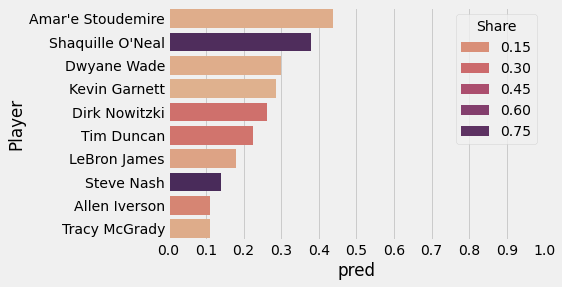

In [181]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
sns.barplot(results_dataframes['normal_stats'].sort_values('pred',ascending=False).head(10),x='pred',y='Player',hue='Share',palette='flare',)
plt.xticks([i/100 for i in range(0,101,10)])
plt.show()

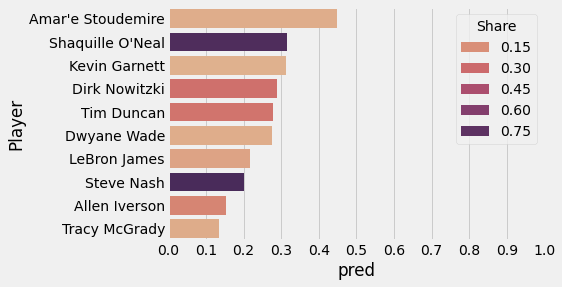

In [182]:
sns.barplot(results_dataframes['off_avg'].sort_values('pred',ascending=False).head(10),x='pred',y='Player',hue='Share',palette='flare',)
plt.xticks([i/100 for i in range(0,101,10)])
plt.show()

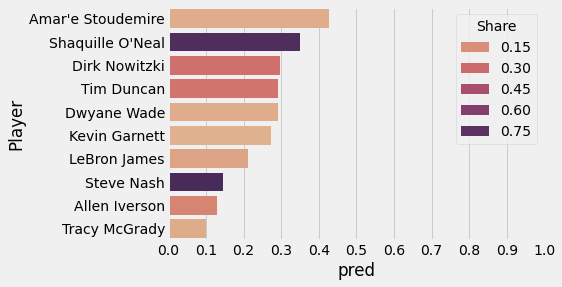

In [183]:
sns.barplot(results_dataframes['z_score'].sort_values('pred',ascending=False).head(10),x='pred',y='Player',hue='Share',palette='flare',)
plt.xticks([i/100 for i in range(0,101,10)])
plt.show()

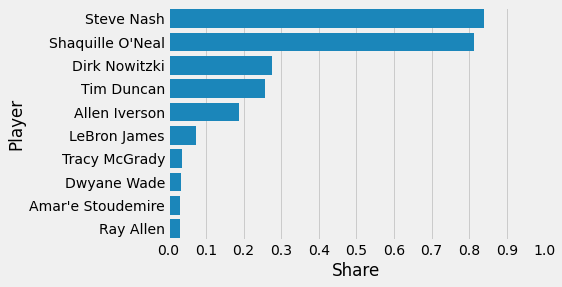

In [184]:
sns.barplot(results_dataframes['normal_stats'].sort_values('Share',ascending=False).head(10),x='Share',y='Player')
plt.xticks([i/100 for i in range(0,101,10)])
plt.show()

Running: normal_stats
Running: off_avg
Running: z_score


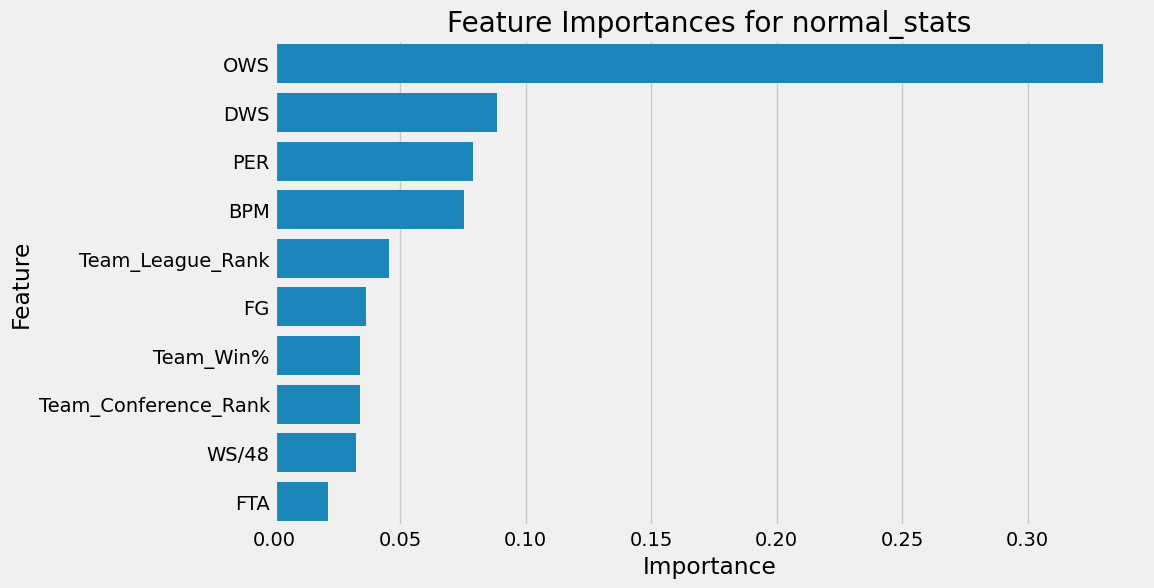

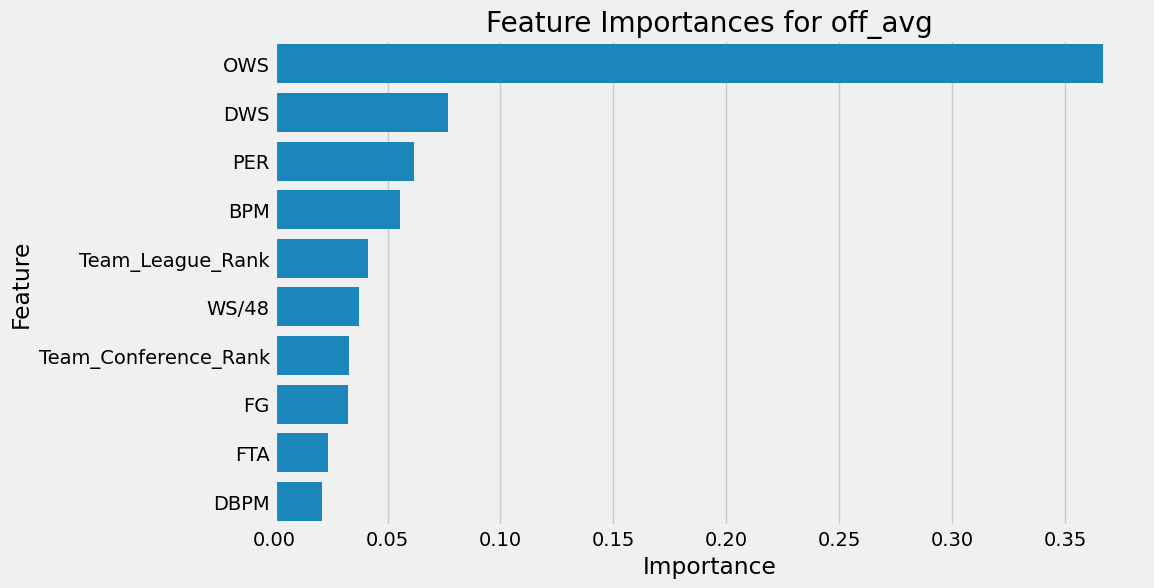

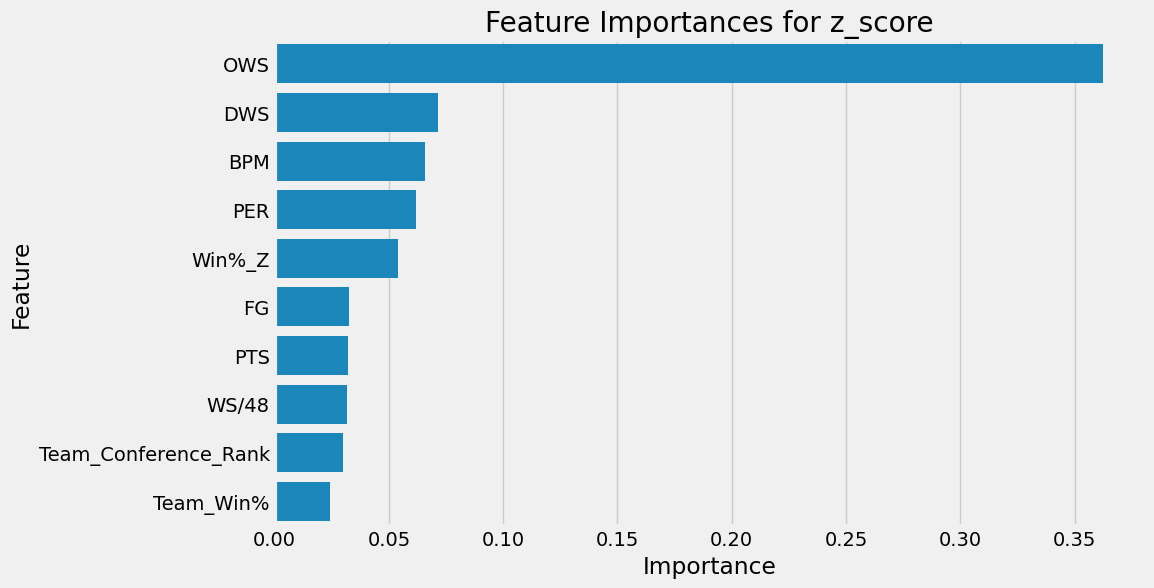

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_sets = {
    'normal_stats': basic_plus_normal_stats,
    'off_avg': basic_plus_off_avg_stats,
    'z_score': basic_plus_z_score_stats
}

feature_importances = {}

for feature_set_name, feat_list in feature_sets.items():
    print(f'Running: {feature_set_name}')

    # Define training and testing sets
    X_train = df[df['Year'] != year][feat_list]
    y_train = df[df['Year'] != year]['Share']

    # Train the model with the best parameters on the training set
    best_model.fit(X_train, y_train)

    # Access the RandomForestRegressor step 'reg' in the pipeline
    forest = best_model.named_steps['reg']
    importances = forest.feature_importances_

    # Get the feature selection step if exists
    feat_selection = best_model.named_steps.get('feat_selection', None)

    if hasattr(feat_selection, 'get_feature_names_out'):
        # Get selected feature names
        selected_features = feat_selection.get_feature_names_out(feat_list)
    else:
        # If feature selection step does not support get_feature_names_out
        # Assuming all features are used
        selected_features = feat_list

    # Ensure the lengths match
    if len(selected_features) == len(importances):
        feature_importances[feature_set_name] = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(10)
    else:
        print(f"Length mismatch in feature importances for {feature_set_name}")

# Plotting the feature importances
for feature_set_name, imp_df in feature_importances.items():
    plt.figure(figsize=(10, 6),dpi=100)
    sns.barplot(data=imp_df, x='Importance', y='Feature')
    plt.title(f'Feature Importances for {feature_set_name}')
    plt.show()

In [186]:
df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FTr_off_avg,FTr_Z,3PAr_off_avg,3PAr_Z,TS%_off_avg,TS%_Z,Win%_off_avg,Win%_Z,Age_off_avg,Age_Z
0,Kareem Abdul-Jabbar,C,32,Los Angeles Lakers,82,0,38.3,10.2,16.9,0.604,...,-0.023636,-0.731275,-0.016636,-1.092781,0.037636,2.381900,2.317073e-01,1.523545e+00,-0.209091,-0.194463
1,Tom Abernethy,PF,25,Golden State Warriors,67,0,18.2,2.3,4.7,0.481,...,-0.045636,-1.411924,-0.013636,-0.895723,-0.011364,-0.719173,-2.073171e-01,-1.363171e+00,-0.109091,-0.101459
2,Alvan Adams,C,25,Phoenix Suns,75,0,28.9,6.2,11.7,0.531,...,0.033364,1.032223,0.008364,0.549376,0.016636,1.052869,1.707317e-01,1.122612e+00,0.090909,0.084549
3,Tiny Archibald,PG,31,Boston Celtics,80,80,35.8,4.8,9.9,0.482,...,0.024364,0.753776,0.026364,1.731730,0.018636,1.179443,2.439024e-01,1.603731e+00,0.890909,0.828581
4,Dennis Awtrey,C,31,Chicago Bulls,26,0,21.5,1.0,2.3,0.450,...,0.065364,2.022258,0.009364,0.615063,0.013636,0.863007,-1.341463e-01,-8.820521e-01,-0.509091,-0.473475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Thaddeus Young,PF,34,Toronto Raptors,54,9,14.7,2.0,3.7,0.545,...,-0.009900,-0.480304,-0.036800,-0.867827,-0.026467,-1.639278,5.551115e-17,4.540967e-16,-0.256667,-0.131887
535,Trae Young,PG,24,Atlanta Hawks,73,73,34.8,8.2,19.0,0.429,...,-0.022900,-1.111007,-0.056800,-1.339472,-0.002467,-0.152779,5.551115e-17,4.540967e-16,-1.156667,-0.594346
536,Omer Yurtseven,C,24,Miami Heat,9,0,9.2,1.8,3.0,0.593,...,0.003100,0.150398,0.020200,0.476361,-0.007467,-0.462466,3.658537e-02,2.992785e-01,1.643333,0.844417
537,Cody Zeller,C,30,Miami Heat,15,2,14.5,2.5,3.9,0.627,...,0.003100,0.150398,0.020200,0.476361,-0.007467,-0.462466,3.658537e-02,2.992785e-01,1.643333,0.844417


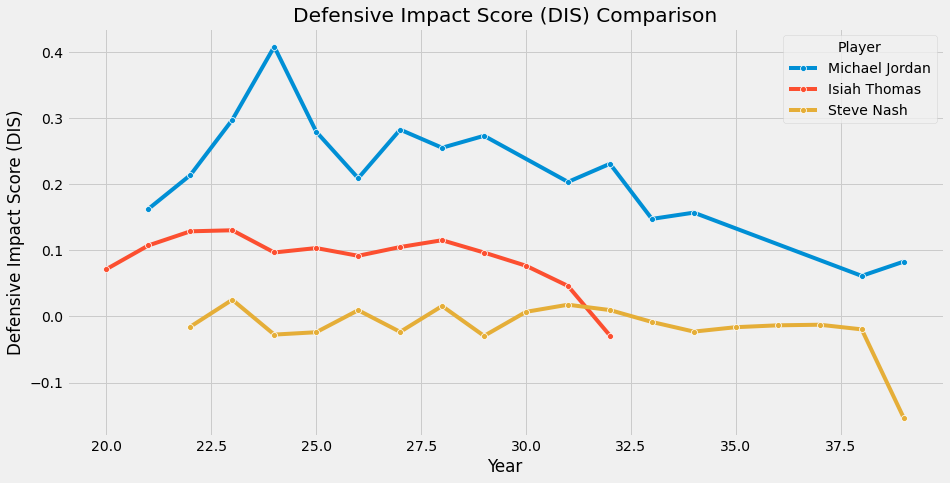

In [200]:
# Replace 'Marc Gasol' and 'Weak_Defender' with the actual names from your dataset
players = ['Michael Jordan', 'Isiah Thomas', 'Steve Nash']
all_players_stats = []

for player in players:
    player_stats = df[df['Player'] == player][['Age', 'STL', 'BLK', 'DWS', 'DBPM', 'G']]
    player_stats['DIS'] = (player_stats['STL'] + player_stats['BLK']) * player_stats['DWS'] + player_stats['DBPM']
    player_stats['DIS'] /= player_stats['G']
    player_stats['Player'] = player  # Add a column for the player's name
    all_players_stats.append(player_stats)

# Combine the data for all players
combined_stats = pd.concat(all_players_stats)

combined_stats.to_clipboard()

# Now plot the data
plt.figure(figsize=(14, 7))
sns.lineplot(data=combined_stats, x='Age', y='DIS', hue='Player', marker='o')
plt.title("Defensive Impact Score (DIS) Comparison")
plt.xlabel("Year")
plt.ylabel("Defensive Impact Score (DIS)")
plt.legend(title='Player')
plt.show()

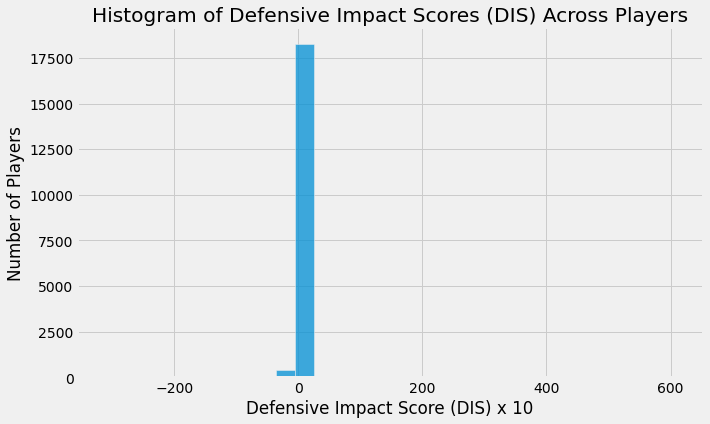

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains the necessary columns

# Calculate DIS for each player and then multiply by 10
df['DIS'] = ((df['STL'] + df['BLK']) * df['DWS'] + df['DBPM']) / df['G'] * 10

# Plotting the histogram of DIS scores
plt.figure(figsize=(10, 6))
sns.histplot(df['DIS'], bins=30, kde=False)

plt.title('Histogram of Defensive Impact Scores (DIS) Across Players')
plt.xlabel('Defensive Impact Score (DIS) x 10')
plt.ylabel('Number of Players')
plt.show()


In [203]:
df.sort_values('DIS',ascending=False)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FTr_Z,3PAr_off_avg,3PAr_Z,TS%_off_avg,TS%_Z,Win%_off_avg,Win%_Z,Age_off_avg,Age_Z,DIS
33,Bruce Bowen,SF,25,Miami Heat,1,0,1.0,0.0,0.0,0.0,...,0.136484,0.086862,2.120267,0.010103,0.545970,0.243902,1.277195,-0.479310,-0.279357,607.0
343,Naz Mitrou-Long,SG,24,Utah Jazz,1,0,1.0,1.0,1.0,1.0,...,0.293289,0.019967,0.420134,0.007800,0.440644,0.085366,0.572734,0.250000,0.153389,427.0
481,Stanley Umude,SG,23,Detroit Pistons,1,0,2.0,0.0,1.0,0.0,...,1.363288,-0.015800,-0.372599,-0.020467,-1.267653,-0.292683,-2.394228,-1.956667,-1.005421,327.0
413,Zhou Qi,PF,23,Houston Rockets,1,0,1.0,1.0,1.0,1.0,...,0.788460,0.160233,3.317814,0.021433,1.422973,0.146341,0.997614,2.923333,2.139259,119.0
132,Javin DeLaurier,C,23,Milwaukee Bucks,1,0,3.0,0.0,0.0,0.0,...,0.482586,0.030367,0.829586,0.013833,0.852711,0.121951,0.864536,2.380000,1.263799,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Barry Sumpter,PF,23,Los Angeles Clippers,1,0,1.0,0.0,1.0,0.0,...,-0.821433,-0.041600,-1.525301,-0.019080,-1.052725,-0.243902,-1.503646,-2.280000,-1.555852,-202.0
280,Mindaugas Kuzminskas,SF,28,New York Knicks,1,0,2.0,0.0,2.0,0.0,...,-1.306470,-0.071033,-1.494665,-0.012200,-0.689213,-0.146341,-0.981829,-0.150000,-0.092034,-217.0
271,Gheorghe Mureșan,C,27,New Jersey Nets,1,0,1.0,0.0,1.0,0.0,...,-0.783141,-0.005448,-0.141025,-0.026828,-1.255818,-0.180000,-1.130056,-1.900000,-0.975505,-232.0
19,Mark Baker,PG,29,Toronto Raptors,1,0,2.0,0.0,1.0,0.0,...,0.171757,-0.000448,-0.011603,-0.007828,-0.366415,-0.040000,-0.251124,-0.600000,-0.308054,-243.0


In [205]:
import pandas as pd

# Assuming 'df' is your DataFrame and it contains the necessary columns

# Calculate DIS for each player
df['DIS'] = ((df['STL'] + df['BLK']) * df['DWS'] + df['DBPM']) / df['G']

# Sort the DataFrame by DIS in descending order and take the top 10
top_dis_players = df.sort_values(by='DIS', ascending=False).head(10)

# Select relevant columns to display
columns_to_display = ['Player', 'Year', 'STL', 'BLK', 'DWS', 'DBPM', 'G', 'DIS']
top_dis_players = top_dis_players[columns_to_display]

# Copy the top 10 players' data to clipboard
top_dis_players.to_clipboard(index=False)

# Print the DataFrame (optional, for your reference)
print(top_dis_players)

               Player  Year  STL  BLK  DWS  DBPM  G   DIS
33        Bruce Bowen  1997  0.0  1.0  0.0  60.7  1  60.7
343   Naz Mitrou-Long  2018  0.0  0.0  0.0  42.7  1  42.7
481     Stanley Umude  2023  1.0  1.0  0.0  32.7  1  32.7
413           Zhou Qi  2019  0.0  0.0  0.0  11.9  1  11.9
132   Javin DeLaurier  2022  1.0  0.0  0.0  11.8  1  11.8
388       Matt Mooney  2022  1.0  0.0  0.0  11.5  1  11.5
51     Marques Bolden  2020  1.0  0.0  0.0  11.3  1  11.3
42        Jordan Bell  2022  1.0  0.0  0.0  10.8  1  10.8
204  Danuel House Jr.  2017  0.0  0.0  0.0   9.8  1   9.8
466     Edmond Sumner  2018  0.0  0.0  0.0   9.3  1   9.3
